### Precision Medicine using Machine Learning 

Once sequenced, a cancer tumor can have thousands of genetic mutations. The time-consuming challenging part is to classify those mutations as tumor growth(drivers) or neutral mutations(passengers). This is a time-consuming and challenging task currently done manually by clinicans based on text-based clinical literature. 

This project uses an expert-annotated knowledge base released by Memorial Sloan Kettering Cancer Center (MSKCC) containing thousands of manually annotated mutations by onclogists. 

Objective: We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import re
#import warnings 
import math
import nltk
from nltk.corpus import stopwords

Step 1: Loading Data 

In [2]:
train_model_variants = pd.read_csv(r"G:\Shared drives\Hack(Her)thon 2023 Project\data\training_variants\training_variants")
train_model_variants.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
train_model_variants.shape

(3321, 4)

In [4]:
test_variants = pd.read_csv(r"G:\Shared drives\Hack(Her)thon 2023 Project\data\test_variants\test_variants")
test_variants.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [5]:
test_variants.shape

(5668, 3)

In [6]:
train_model_text = pd.read_csv(r"G:\Shared drives\Hack(Her)thon 2023 Project\data\training_text\training_text", sep="\|\|", names=["ID", "Text"], skiprows=1, engine="python", encoding="latin-1")
train_model_text.head()


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
test_text = pd.read_csv(r"G:\Shared drives\Hack(Her)thon 2023 Project\data\test_text\test_text", sep="\|\|", names=["ID", "Text"], skiprows=1, engine="python", encoding="latin-1")
test_text.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [8]:
#right not the training_text's 'TEXT' column needs cleaning so that it can be processed to look for data that indicates cancerous class

#loading stop words from nltk library 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_text(full_text, index, column):
    if type(full_text) is not str:
        full_text = str(full_text)
    
    new_text = ""
    empty_string = ' '
    full_text = re.sub('[^a-zA-Z0-9\n]', empty_string, full_text)
    full_text = re.sub('\s+', empty_string, full_text)
    full_text = full_text.lower()

    for word in full_text.split():
        if not word in stop_words:
            new_text += word + " "
    
    train_model_text[column][index] = new_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chawl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#column 1109 in 'Text' created issues because it was null. And initial type float
cleaning_text(train_model_text['Text'][1109], 1109, 'Text')
type(train_model_text['Text'][1109])

C:\Users\chawl\AppData\Local\Temp\ipykernel_21704\3679951068.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model_text[column][index] = new_text


str

In [10]:
#processing all the text in the training set

for index, row in train_model_text.iterrows():
    cleaning_text(row['Text'], index, 'Text')

C:\Users\chawl\AppData\Local\Temp\ipykernel_21704\3679951068.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model_text[column][index] = new_text


In [11]:
#Merging Training Text and Training Variants
training_dataframe = pd.merge(train_model_variants, train_model_text, on = "ID")
training_dataframe.head()


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
test_dataframe = pd.merge(test_variants, test_text, on = "ID")
test_dataframe.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [13]:
#fixing the variation column 
training_dataframe.Variation= training_dataframe.Variation.str.replace('\s+', '_')

C:\Users\chawl\AppData\Local\Temp\ipykernel_21704\736478266.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_dataframe.Variation= training_dataframe.Variation.str.replace('\s+', '_')


Step 2: Splitting the dataset for Training, Validation and Testing

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#split the class column from the dataframe since we are trying to predict it
X = training_dataframe.copy()
y = training_dataframe['Class'].values

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8)

X_vaildation, X_test, y_validation, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [16]:
print("Number of records in training set:", X_train.shape)
print("Number of records in Cross validation set:", X_vaildation.shape)
print("Number of records in testing set:", X_test.shape)


Number of records in training set: (2656, 5)
Number of records in Cross validation set: (332, 5)
Number of records in testing set: (333, 5)


In [17]:
import collections
from collections import Counter
z_train = y_train.tolist()
d_train = Counter(z_train)
print(d_train)

Counter({7: 768, 4: 549, 1: 443, 2: 361, 6: 219, 5: 196, 3: 77, 9: 27, 8: 16})


In [18]:

s = sum(d_train.values())
for k,v in d_train.items():
    pct = v* 100.0/s
    d_train[k] = pct
print(d_train)
print(type(d_train))
#print(d.values())

z_cv = y_validation.tolist()
d_cv = Counter(z_cv)
s2 = sum(d_cv.values())
for k,v in d_cv.items():
    pct = v* 100.0/s2
    d_cv[k] = pct
print(d_cv)


z_testing = y_test.tolist()
d_testing = Counter(z_testing)

s3 = sum(d_testing.values())
for k,v in d_testing.items():
    pct = v* 100.0/s3
    d_testing[k] = pct
print(d_testing)

Counter({7: 28.91566265060241, 4: 20.670180722891565, 1: 16.67921686746988, 2: 13.591867469879517, 6: 8.245481927710843, 5: 7.379518072289157, 3: 2.8990963855421685, 9: 1.016566265060241, 8: 0.6024096385542169})
<class 'collections.Counter'>
Counter({7: 29.518072289156628, 1: 20.783132530120483, 4: 18.97590361445783, 2: 13.55421686746988, 5: 7.530120481927711, 6: 6.927710843373494, 3: 1.8072289156626506, 9: 0.6024096385542169, 8: 0.30120481927710846})
Counter({7: 26.126126126126128, 4: 22.22222222222222, 1: 16.816816816816818, 2: 13.813813813813814, 6: 9.90990990990991, 5: 6.306306306306307, 9: 2.4024024024024024, 3: 1.8018018018018018, 8: 0.6006006006006006})


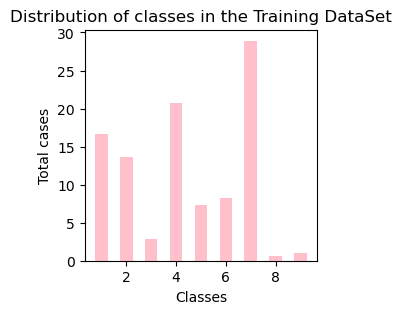

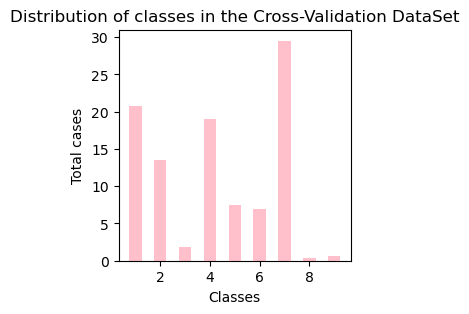

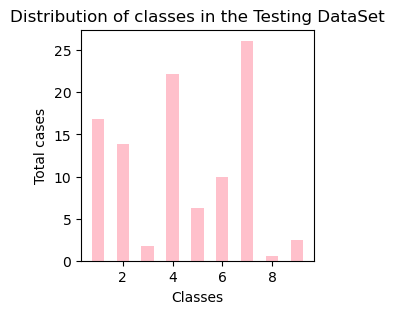

In [19]:
#Distribution of classes across all 3 datsets: Training, cross validation and testing should be fair 

#1. training
fig_train = plt.figure(figsize=(3,3))
plt.bar(d_train.keys(), d_train.values(), color = 'pink', width = 0.5)
plt.xlabel("Classes")
plt.ylabel("Total cases")
plt.title("Distribution of classes in the Training DataSet")
plt.show()

#2. cross-validation
fig_cv = plt.figure(figsize=(3,3))
plt.bar(d_cv.keys(), d_cv.values(), color = 'pink', width = 0.5)
plt.xlabel("Classes")
plt.ylabel("Total cases")
plt.title("Distribution of classes in the Cross-Validation DataSet")
plt.show()

#3. testing
fig = plt.figure(figsize=(3,3))
plt.bar(d_testing.keys(), d_testing.values(), color = 'pink', width = 0.5)
plt.xlabel("Classes")
plt.ylabel("Total cases")
plt.title("Distribution of classes in the Testing DataSet")
plt.show()


Setting performance Standards for the model: Log Loss

For a multi-classification problem where each class has an equal probability of being classified, 
log_loss = -log(1/M)    where M is the number of classes
-log(1/9) = 0.954

But that is not the case here. As we saw from the graphs above, all 3 dataset are unequally distributed over classes. 
So, how do we calculate log-loss for imbalanced multi-class problem.

By my calculation, the random guessing log-loss for this imbalanced multi class(K=9) problem comes out as 1.829
Pictures of calculation on github.

Therefore, our model has to do better than this i.e. logloss<1.829

### Univariate Analysis

##### Gene Feature

In [20]:
#unique, number of occuerences of each gene, cumulative distribution 
unique_genes =X_train.value_counts('Gene')   
print("There are", unique_genes.shape[0], "different categories of genes in the training data" )
print(unique_genes)

There are 244 different categories of genes in the training data
Gene
BRCA1      220
TP53       117
EGFR       113
PTEN       106
BRCA2       89
          ... 
LATS1        1
KLF4         1
BCL2L11      1
KDM6A        1
FLT1         1
Length: 244, dtype: int64


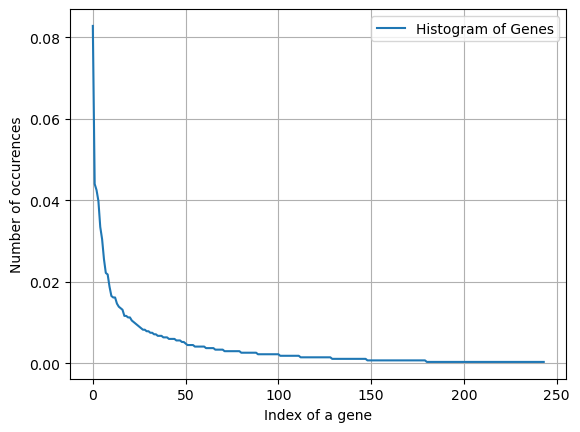

In [21]:
s= sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histogram of Genes")
plt.ylabel("Number of occurences")
plt.xlabel("Index of a gene")
plt.legend()
plt.grid()
plt.show()

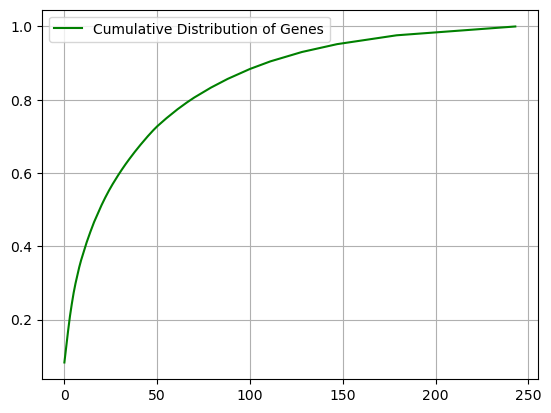

Top 50 most frequent genes nearly contribute to 75% of data


In [22]:
cdf = np.cumsum(h)
plt.plot(cdf, color ="green", label = "Cumulative Distribution of Genes")
plt.legend()
plt.grid()
plt.show()
print("Top 50 most frequent genes nearly contribute to 75% of data")


Converting the genes into vectore by Response Coding and One-Hot Encoding


In [23]:
#In Response Coding, each level of a categorical variable is assigned a probability value based 
#on the propoertion of positive class observations for that level.

#response coding for a gene using laplace smoothing 
alpha = 1

#Creating a mehtod for gene one-hot encoding that can be used for all 3 data sets 
def gene_response_coding(df):
    gene_dict = dict()
    values = df['Gene'].value_counts()
    for gene, freq in values.items():
        prob_vec = []
        for cancer_class in range(1,10):
            class_occurence = df.loc[(df['Class'] == cancer_class) & (df['Gene'] == gene)]
            prob_vec.append((class_occurence.shape[0] + alpha)/(freq + (alpha * values.shape[0])))
        gene_dict[gene] = prob_vec
    
    return gene_dict


train_gene_responseCoding = gene_response_coding(X_train)
cv_gene_responseCoding = gene_response_coding(X_vaildation)
test_gene_responseCoding = gene_response_coding(X_test)
print("Here's the first 10 items in the Gene array after response coding: \n")
from itertools import islice
n_items = list(islice(train_gene_responseCoding.items(), 10))
for i in range(0,10):
    print(n_items[i]) 







Here's the first 10 items in the Gene array after response coding: 

('BRCA1', [0.10560344827586207, 0.0021551724137931034, 0.034482758620689655, 0.07543103448275862, 0.17672413793103448, 0.09267241379310345, 0.0021551724137931034, 0.0021551724137931034, 0.0021551724137931034])
('TP53', [0.1772853185595568, 0.00554016620498615, 0.00554016620498615, 0.1329639889196676, 0.008310249307479225, 0.0110803324099723, 0.002770083102493075, 0.002770083102493075, 0.002770083102493075])
('EGFR', [0.0056022408963585435, 0.10084033613445378, 0.0028011204481792717, 0.014005602240896359, 0.011204481792717087, 0.0028011204481792717, 0.19607843137254902, 0.0056022408963585435, 0.0028011204481792717])
('PTEN', [0.011428571428571429, 0.002857142857142857, 0.017142857142857144, 0.27714285714285714, 0.005714285714285714, 0.002857142857142857, 0.005714285714285714, 0.002857142857142857, 0.002857142857142857])
('BRCA2', [0.02702702702702703, 0.003003003003003003, 0.003003003003003003, 0.009009009009009009, 0.

In [24]:
# So if you look at the first entry BRCA 1, its mutatations have the highest probability of being in class 5 
#Then, the probability of the mutation falling under class 1, 4, 6 is nearly the same 

In [25]:

#One Hot Encoding is a representation of categorical variables as binary vectors to be used in a machine learning model.

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
train_gene_oneHotEncoding = encoder.fit_transform(X_train[['Gene']])
cv_gene_oneHotEncoding = encoder.transform(X_vaildation[['Gene']])
test_gene_oneHotEncoding = encoder.transform(X_test[['Gene']])

print("The 'Gene' column of the training dataset once transformed using one hot encoding has shape: ", train_gene_oneHotEncoding.shape)

The 'Gene' column of the training dataset once transformed using one hot encoding has shape:  (2656, 244)


In [26]:
#Building a model just based on the gene feature 
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
sgdc_gene_model = SGDClassifier()    # default method = 'sigmoid'  (logistic regression model) 
sgdc_gene_model.fit(train_gene_oneHotEncoding, y_train)

#Calibrated Classification
calibrator  = CalibratedClassifierCV(sgdc_gene_model)
calibrator.fit(cv_gene_oneHotEncoding, y_validation)
ypredict_cal_test = calibrator.predict_proba(test_gene_oneHotEncoding)  

# printed for my own understanding 
#print(y_test)   
#print(y_test.shape)
#print(ypredict_cal_test[:, 1])
#print(ypredict_cal_test[:, 1].shape)
from sklearn.metrics import log_loss
log_loss_test = log_loss(y_test, ypredict_cal_test, labels=sgdc_gene_model.classes_)
print("When model trained on just 'Gene' feature, the log loss for test data is ", log_loss_test)




When model trained on just 'Gene' feature, the log loss for test data is  1.6249787609089872


c:\Users\chawl\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [27]:
#Question: How many genes in the cross-validation and testing set are the same unique_genes that were encountered in the training set? 
print("Number of unique genes in training set: ", unique_genes.shape[0])
unique_genes_cv = X_vaildation['Gene'].value_counts()
unique_genes_test = X_test['Gene'].value_counts()
print("Number of unique genes in cross-validation set ", unique_genes_cv.shape[0])
print("Number of unique genes in testing set ", unique_genes_test.shape[0])

counter = 0

for i in unique_genes_cv.index:
    if i not in unique_genes.index:
        counter +=1

print("Percentage of genes in cross-validation set that have not been encountered in the training dataset = ", counter/unique_genes_cv.shape[0]*100)

counter2 =0
for i in unique_genes_test.index:
    if i not in unique_genes.index:
        counter2 +=1

print("Percentage of genes in Testing set that have not been encountered in the training dataset = ", counter2/unique_genes_test.shape[0]*100)


Number of unique genes in training set:  244
Number of unique genes in cross-validation set  109
Number of unique genes in testing set  109
Percentage of genes in cross-validation set that have not been encountered in the training dataset =  11.926605504587156
Percentage of genes in Testing set that have not been encountered in the training dataset =  6.422018348623854


Variation feature

In [28]:
#Number of unique variations 

print("Number of variations in training set: ", X_train['Variation'].shape[0])
unique_variations = X_train['Variation'].value_counts()
print("Total number of unique variations in training set: ", unique_variations.shape[0])
print("Top ten most frequently occuring variations are:\n", unique_variations.head(10))

Number of variations in training set:  2656
Total number of unique variations in training set:  2406
Top ten most frequently occuring variations are:
 Truncating_Mutations    70
Amplification           59
Deletion                57
Fusions                 28
Overexpression           5
G12V                     4
Q61L                     3
E17K                     3
F384L                    2
Q209L                    2
Name: Variation, dtype: int64


In [29]:
#Overlap between training, CV, and Testing set 
unique_variations_cv = X_vaildation['Variation'].value_counts()

counter3 =0
for i in unique_variations_cv.index:
    if i not in unique_variations.index:
        counter3 +=1

print("Percentage of variations in cross-validation set that have not been encountered in the training dataset = ", (counter3/unique_variations_cv.shape[0])*100)

unique_variations_test = X_test['Variation'].value_counts()

counter4 =0
for i in unique_variations_test.index:
    if i not in unique_variations.index:
        counter4 +=1

print("Percentage of variations in cross-validation set that have not been encountered in the training dataset = ", (counter4/unique_variations_test.shape[0])*100)




Percentage of variations in cross-validation set that have not been encountered in the training dataset =  96.36963696369637
Percentage of variations in cross-validation set that have not been encountered in the training dataset =  96.45161290322581


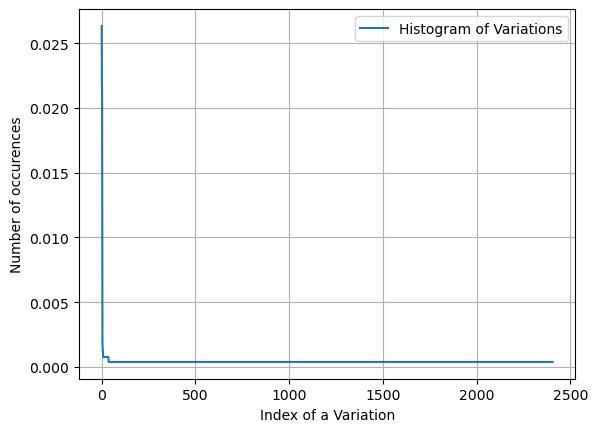

In [30]:
#histogram to see frequency of variations
s2= sum(unique_variations.values)
h2 = unique_variations.values/s2
plt.plot(h2, label = "Histogram of Variations")
plt.ylabel("Number of occurences")
plt.xlabel("Index of a Variation")
plt.legend()
plt.grid()
plt.show()

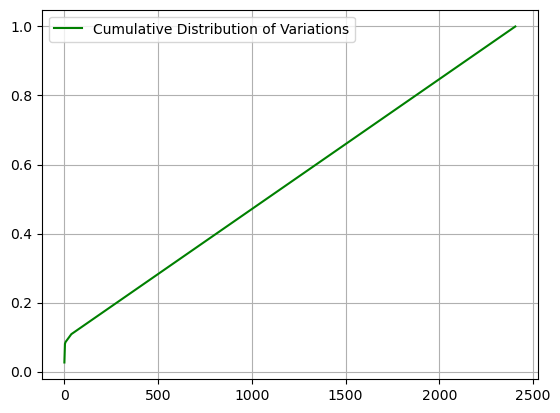

Constant growth of cdf graph, meaning almost all genes contribute equally to the dataset


In [31]:
#cumulative distribution of variations 
cdf2 = np.cumsum(h2)
plt.plot(cdf2, color ="green", label = "Cumulative Distribution of Variations")
plt.legend()
plt.grid()
plt.show()
print("Constant growth of cdf graph, meaning almost all genes contribute equally to the dataset")

In [32]:
#Response Coding of variations
def variation_response_coding(df):
    var_dict = dict()
    values = df['Variation'].value_counts()
    for var, freq in values.items():
        prob_vec = []
        for cancer_class in range(1,10):
            class_occurence = df.loc[(df['Class'] == cancer_class) & (df['Variation'] == var)]
            prob_vec.append((class_occurence.shape[0] + alpha)/(freq + (alpha * values.shape[0])))
        var_dict[var] = prob_vec
    
    return var_dict


train_var_responseCoding = variation_response_coding(X_train)
cv_var_responseCoding = variation_response_coding(X_vaildation)
test_var_responseCoding = variation_response_coding(X_test)
print("Here's the first 10 items in the Variation array after response coding: \n")
from itertools import islice
n_items2 = list(islice(train_var_responseCoding.items(), 10))
for i in range(0,10):
    print(n_items2[i]) 

print("\n")
print("From the first 10 variations shown above, we can see that if it is a Truncating Mutation, it has the highest probability to belong to class 1")

Here's the first 10 items in the Variation array after response coding: 

('Truncating_Mutations', [0.027463651050080775, 0.0008077544426494346, 0.0004038772213247173, 0.0008077544426494346, 0.0004038772213247173, 0.0008077544426494346, 0.0004038772213247173, 0.0004038772213247173, 0.0004038772213247173])
('Amplification', [0.00040567951318458417, 0.008113590263691683, 0.00040567951318458417, 0.00040567951318458417, 0.00040567951318458417, 0.004056795131845842, 0.012981744421906694, 0.00040567951318458417, 0.00040567951318458417])
('Deletion', [0.017864393016646368, 0.0004060089321965083, 0.0004060089321965083, 0.005684125050751117, 0.0004060089321965083, 0.0008120178643930166, 0.0004060089321965083, 0.0004060089321965083, 0.0004060089321965083])
('Fusions', [0.0012325390304026294, 0.010682004930156122, 0.0004108463434675431, 0.0004108463434675431, 0.0004108463434675431, 0.0004108463434675431, 0.0004108463434675431, 0.0008216926869350862, 0.0004108463434675431])
('Overexpression', [0.0

In [33]:
#one-hot encoding of variations 

train_var_oneHotEncoding = encoder.fit_transform(X_train[['Variation']])
cv_var_oneHotEncoding = encoder.transform(X_vaildation[['Variation']])
test_var_oneHotEncoding = encoder.transform(X_test[['Variation']])


print("The 'Variation' column of the training dataset once transformed using one hot encoding has shape: ", train_var_oneHotEncoding.shape, "\n")
print("Printing the first row: ")
print(train_var_oneHotEncoding[1])

The 'Variation' column of the training dataset once transformed using one hot encoding has shape:  (2656, 2406) 

Printing the first row: 
  (0, 1765)	1.0


In [34]:
#Building a model just based on 'Variation' feature and seeing how effective it is in prediciting 'Class'
#for future purposes, alpha could be varied to see how the model performance increases or decreses, but for my first project I'll just go with default alpha = 0.0001

sgdc_var_model = SGDClassifier()    # default method = 'sigmoid'  (logistic regression model) 
sgdc_var_model.fit(train_var_oneHotEncoding, y_train)

#Calibrated Classification
calibrator2  = CalibratedClassifierCV(sgdc_var_model)
calibrator2.fit(cv_var_oneHotEncoding, y_validation)
ypredict_cal_test2 = calibrator2.predict_proba(test_var_oneHotEncoding)  

log_loss_test_var = log_loss(y_test, ypredict_cal_test2, labels=sgdc_var_model.classes_)
print("When model trained on just 'Variation' feature, the log loss for test data is ", log_loss_test_var)

When model trained on just 'Variation' feature, the log loss for test data is  1.799630234372917


c:\Users\chawl\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


'Text' Feature 

In [35]:
#Overlap between Train, CV and Test set 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

train_text_allwords = CountVectorizer()
train_text_allwords_vec = train_text_allwords.fit_transform(X_train['Text'])
print("Total number of unique words in training set: ", len(train_text_allwords.vocabulary_))

text_cv_vectorizer = CountVectorizer()
validation_text_onehotencoding  = text_cv_vectorizer.fit_transform(X_vaildation['Text'])
print("Total number of unique words in cross-validation set: ", len(text_cv_vectorizer.vocabulary_))

text_test_vectorizer = CountVectorizer()
test_text_onehotencoding  = text_test_vectorizer.fit_transform(X_test['Text'])
print("Total number of unique words in testing set: ", len(text_test_vectorizer.vocabulary_), "\n")

counter5 =0
for i in text_cv_vectorizer.vocabulary_.keys():
    if i not in train_text_allwords.vocabulary_.keys():
        counter5 +=1

#print(counter5)

print("Percentage of words in cross-validation set that have not been encountered in the training dataset = ", (counter5/len(text_cv_vectorizer.vocabulary_))*100)


counter6 =0
for i in text_test_vectorizer.vocabulary_.keys():
    if i not in train_text_allwords.vocabulary_.keys():
        counter6 +=1


print("Percentage of words in testing set that have not been encountered in the training dataset = ", (counter6/len(text_test_vectorizer.vocabulary_))*100)


Total number of unique words in training set:  138265
Total number of unique words in cross-validation set:  54558
Total number of unique words in testing set:  53565 

Percentage of words in cross-validation set that have not been encountered in the training dataset =  14.10059019758789
Percentage of words in testing set that have not been encountered in the training dataset =  14.177167926817885


In [36]:
# one-hot encoding 
#for words that occured atleast five times in the dataset 


#building TfidVectorizer with all words that occured min 5 times in training data

text_vectorizer = TfidfVectorizer(min_df =5, binary=True, use_idf=True)
train_text_onehotencoding = text_vectorizer.fit_transform(X_train['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
print("Total number of unique words that occured atleast 5 times in training set: ", len(train_text_features))

cv_text_onehotencoding = text_vectorizer.transform(X_vaildation['Text'])

test_text_onehotencoding = text_vectorizer.transform(X_test['Text'])


#normalizing to [0,1]
from sklearn.preprocessing import normalize
train_text_onehotencoding = normalize(train_text_onehotencoding, axis =0)
cv_text_onehotencoding = normalize(cv_text_onehotencoding, axis =0)
test_text_onehotencoding = normalize(test_text_onehotencoding, axis =0)


c:\Users\chawl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Total number of unique words that occured atleast 5 times in training set:  43391


In [37]:
#building a model based on just 'Text' feature to see how well it is able to predict class

sgdc_text_model = SGDClassifier(loss = 'log', random_state=42, penalty="l2")    # default method = 'sigmoid'  (logistic regression model) 
sgdc_text_model.fit(train_text_onehotencoding, y_train)

#Calibrated Classification
calibrator3  = CalibratedClassifierCV(sgdc_text_model, method = 'sigmoid')
calibrator3.fit(train_text_onehotencoding, y_train)
predict_y = calibrator3.predict_proba(cv_text_onehotencoding)  

log_loss_test_text = log_loss(y_validation, predict_y, labels=sgdc_text_model.classes_)
print("When model trained on just 'Text' feature, the log loss for test data is ", log_loss_test_text)

When model trained on just 'Text' feature, the log loss for test data is  1.3097283788034129


Stacking all 3 features to prepare for model 

In [38]:
print(train_gene_oneHotEncoding.shape)
print(type(train_gene_oneHotEncoding))
print(train_var_oneHotEncoding.shape)
print(type(train_var_oneHotEncoding))

(2656, 244)
<class 'scipy.sparse.csr.csr_matrix'>
(2656, 2406)
<class 'scipy.sparse.csr.csr_matrix'>


In [39]:
from scipy.sparse import hstack

train_gv_ohc = hstack((train_var_oneHotEncoding, train_gene_oneHotEncoding))
cv_gv_ohc = hstack((cv_gene_oneHotEncoding, cv_var_oneHotEncoding))
test_gv_ohc = hstack((test_gene_oneHotEncoding, test_var_oneHotEncoding))

train_X_onehotencoding = hstack((train_gv_ohc, train_text_onehotencoding))

cv_X_onehotencoding = hstack((cv_gv_ohc, cv_text_onehotencoding))

test_X_onehotencoding = hstack((test_gv_ohc, test_text_onehotencoding))


In [40]:
#Final dataset features 

print("(Number of records, number of features) in the final dataset use for training is: ", train_X_onehotencoding.shape)
print("(Number of records, number of features) in the final dataset use for cross-validation is: ", cv_X_onehotencoding.shape)
print("(Number of records, number of features) in the final dataset use for testing is: ", test_X_onehotencoding.shape)

(Number of records, number of features) in the final dataset use for training is:  (2656, 46041)
(Number of records, number of features) in the final dataset use for cross-validation is:  (332, 46041)
(Number of records, number of features) in the final dataset use for testing is:  (333, 46041)


#### Machine Learning Models

Linear Support Vector Machine 

In [41]:
svm = SGDClassifier(loss='hinge', random_state=42) 
#loss ='hinge' gives linear SVM
#default penalty='l2' which is the standard regulizer for SVM 

svm.fit(train_X_onehotencoding, y_train)
calibrated_svm = CalibratedClassifierCV(svm, method= 'sigmoid')
calibrated_svm.fit(train_X_onehotencoding, y_train)
calibrated_svm_cv_predict = calibrated_svm.predict_proba(cv_X_onehotencoding)
calibrated_svm_train_predict = calibrated_svm.predict_proba(train_X_onehotencoding)
calibrated_svm_test_predict = calibrated_svm.predict_proba(test_X_onehotencoding)
log_loss_svm_cv = log_loss(y_validation, calibrated_svm_cv_predict)
log_loss_svm_train = log_loss(y_train, calibrated_svm_train_predict)
log_loss_svm_test = log_loss(y_test, calibrated_svm_test_predict)


print("Log Loss with Support Vector Machine on Training set: ", log_loss_svm_train)
print("Log Loss with Support Vector Machine on Cross-Validatiob set: ", log_loss_svm_cv)
print("Log Loss with Support Vector Machine on Testing set: ", log_loss_svm_test)




Log Loss with Support Vector Machine on Training set:  0.49413293509235245
Log Loss with Support Vector Machine on Cross-Validatiob set:  1.379463690206224
Log Loss with Support Vector Machine on Testing set:  1.2134525598397619


##### Evaluating The SVM Model Performance 

In [42]:
from sklearn.metrics import classification_report

y_test_predict = calibrated_svm.predict(test_X_onehotencoding)
print(classification_report(y_test, y_test_predict, zero_division =0))

              precision    recall  f1-score   support

           1       0.74      0.45      0.56        56
           2       0.72      0.46      0.56        46
           3       0.33      0.33      0.33         6
           4       0.64      0.76      0.70        74
           5       0.41      0.33      0.37        21
           6       0.81      0.64      0.71        33
           7       0.63      0.91      0.74        87
           8       0.00      0.00      0.00         2
           9       0.71      0.62      0.67         8

    accuracy                           0.65       333
   macro avg       0.56      0.50      0.51       333
weighted avg       0.66      0.65      0.63       333



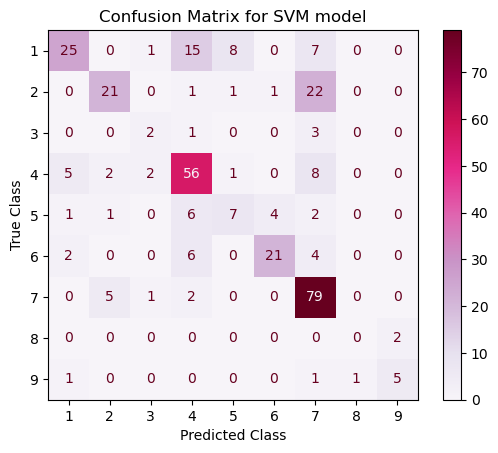

In [63]:
from  sklearn.metrics import plot_confusion_matrix, confusion_matrix,ConfusionMatrixDisplay
confusion_matrix_svm = confusion_matrix(y_test, y_test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=calibrated_svm.classes_)
disp.plot(cmap = "PuRd")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for SVM model")
plt.show()